In [66]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import fmin_cg

# 编程练习8：异常检测与推荐系统
第一部分我们实现一个检测服务器异常的算法，第二部分实现一个电影推荐系统。  
## 1 异常检测
### 1.2 估计高斯参数
这里我们实现高斯估计并把图画出来。  
如果是多元高斯估计，对应的函数使用均值和协方差矩阵。  
如果是各变量之间是独立的，可以算出方差后将其转为对角，就是协方差矩阵。  

In [67]:
raw_data = loadmat('ex8data1.mat')
X = np.mat(raw_data['X'])
Xval = np.mat(raw_data['Xval'])
yval = np.mat(raw_data['yval'])

In [68]:
def multivariateGaussian(X, mu, sigma2):
    D = X - np.mat(mu)
    sigma2 = np.diagflat(sigma2)
    coef = 1/np.power(2*np.pi, 0.5*X.shape[1])/np.sqrt(np.linalg.det(sigma2))
    det = np.linalg.inv(sigma2)
    return np.mat([coef*np.exp(-0.5*d*det*d.T)[0,0] for d in D]).reshape((X.shape[0],1))

In [69]:
mu = np.mean(X, axis=0)
sigma2 = np.var(X, ddof=0, axis=0)

### 1.3 选择阈值
我们在交叉验证集上使用不同的epsilon，比较F1指数，选择最佳的epsilon阈值。

In [70]:
def selectThreshold(yval, pval):
    bestEpsilon = 0
    bestF1 = 0
    for epsilon in np.linspace(np.min(pval), np.max(pval), 1000):
        predictions = pval < epsilon
        tp = np.sum((predictions==1) & (yval==1))
        fp = np.sum((predictions==1) & (yval==0))
        fn = np.sum((predictions==0) & (yval==1))
        prec = 1 / (1+fp/tp)
        rec = 1 / (1+fn/tp)
        F1 = 2*prec*rec / (prec+rec)
        if F1>bestF1:
            bestEpsilon = epsilon
            bestF1 = F1
    return bestEpsilon, bestF1

In [71]:
pval = multivariateGaussian(Xval, mu, sigma2)
bestEpsilon, bestF1 = selectThreshold(yval, pval)
print('Best\t\tEpsilon and F1: %s\t%s\nExpected\tEpsilon and F1: 8.99e-5\t\t\t0.875' % (bestEpsilon, bestF1))

Best		Epsilon and F1: 8.999852631901395e-05	0.8750000000000001
Expected	Epsilon and F1: 8.99e-5			0.875


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


最后我们统一可视化一下，把拟合结果和阈值选择出来的异常点画出来。

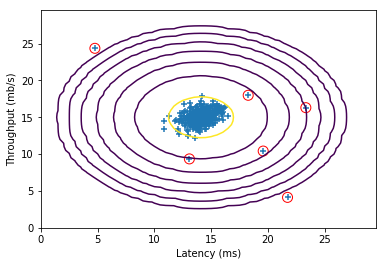

In [72]:
space = np.arange(0,30,0.5)
X1,X2 = np.meshgrid(space, space)
Xgrid = np.vstack([X1.flatten(), X2.flatten()]).T
Z = multivariateGaussian(Xgrid, mu, sigma2).reshape(X1.shape)
outliers = X[multivariateGaussian(X,mu,sigma2).A1 < bestEpsilon]
fig, ax = plt.subplots()
ax.scatter(X[:,0].A1, X[:,1].A1, marker='+')
ax.scatter(outliers[:,0].A1, outliers[:,1].A1, marker='o', color='', edgecolor='r', s=100)
ax.contour(X1, X2, Z, np.power(10.0, np.arange(-20,0,3)))
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()

### 1.4 高维数据
最后我们看看高维数据的表现，这次将多元高斯异常检测用于11维的数据。

In [73]:
raw_data = loadmat('ex8data2.mat')
X = np.mat(raw_data['X'])
Xval = np.mat(raw_data['Xval'])
yval = np.mat(raw_data['yval'])
mu = np.mean(X, axis=0)
sigma2 = np.var(X, ddof=0, axis=0)
pval = multivariateGaussian(Xval, mu, sigma2)
bestEpsilon, bestF1 = selectThreshold(yval, pval)
num_outliers = np.sum(multivariateGaussian(X,mu,sigma2) < bestEpsilon)
print('Best\t\tEpsilon and num_outliers: %s\t%s\nExpected\tEpsilon and num_outliers: 1.38e-18\t\t\t117' % (bestEpsilon, num_outliers))

Best		Epsilon and num_outliers: 1.3786074982000245e-18	117
Expected	Epsilon and num_outliers: 1.38e-18			117


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


## 2 推荐系统
这部分我们实现一个推荐系统，对有若干用户和电影的数据集进行协同过滤。  
### 2.2 协同过滤学习算法
X对应于用户，Theta对应于电影，y对应于评分。

In [74]:
def unfoldParams(params, num_users, num_movies, num_features):
    X = np.mat(params[:num_movies*num_features]).reshape((num_movies, num_features))
    Theta = np.mat(params[num_movies*num_features:]).reshape((num_users, num_features))
    return X, Theta

def cofiCost(params, *args):
    Y, R, num_users, num_movies, num_features, lamda = args
    X, Theta = unfoldParams(params, num_users, num_movies, num_features)
    D = np.multiply(X*Theta.T-Y, R)
    J = 0.5 * np.sum(np.power(D,2)) + lamda*np.sum(np.power(X,2)) + lamda*np.sum(np.power(Theta,2))
    return J

def cofiGrad(params, *args):
    Y, R, num_users, num_movies, num_features, lamda = args
    X, Theta = unfoldParams(params, num_users, num_movies, num_features)
    X_grad = np.mat(np.zeros(X.shape))
    Theta_grad = np.mat(np.zeros(Theta.shape))
    for i in range(num_movies):
        idx = (R[i,:]==1).A1
        Thetatemp = Theta[idx,:]
        Ytemp = Y[i, idx]
        X_grad[i,:] = (X[i,:]*Thetatemp.T - Ytemp) * Thetatemp + lamda*X[i,:]
    for j in range(num_users):
        idx = (R[:,j]==1).A1
        Xtemp = X[idx,:]
        Ytemp = Y[idx, j]
        Theta_grad[j,:] = (Xtemp*Theta[j,:].T - Ytemp).T * Xtemp + lamda*Theta[j,:]
    grad = np.hstack([X_grad.A1, Theta_grad.A1])
    return grad
    
def calcNumGrad(cost, params, *args):
    numgrad = np.zeros(params.shape)
    perturb = np.zeros(params.shape)
    e = 1e-4
    for p in range(len(params)):
        perturb[p] = e
        loss1 = cost(params-perturb, *args)
        loss2 = cost(params+perturb, *args)
        numgrad[p] = (loss2 - loss1) / (2*e)
        perturb[p] = 0
    return numgrad

我们首先实现正则化的代价函数和梯度函数，然后取一小部分数据测试代价函数，用数值梯度校验梯度函数。

In [75]:
raw_data = dict(loadmat('ex8_movieParams.mat'), **loadmat('ex8_movies.mat'))
num_users = 4
num_movies = 5
num_features = 3;
X = np.mat(raw_data['X'])[0:num_movies, 0:num_features]
Theta = np.mat(raw_data['Theta'])[0:num_users, 0:num_features]
Y = np.mat(raw_data['Y'])[0:num_movies, 0:num_users]
R = np.mat(raw_data['R'])[0:num_movies, 0:num_users]
params = np.hstack([X.A1, Theta.A1])
J = cofiCost(params, Y, R, num_users, num_movies, num_features, 0)
print('Test J:\t\t%s\nExpected:\t22.22'%J)
numgrad = calcNumGrad(cofiCost, params, Y, R, num_users, num_movies, num_features, 0)
cofigrad = cofiGrad(params, Y, R, num_users, num_movies, num_features, 0)
diff = np.linalg.norm(numgrad-cofigrad) / np.linalg.norm(numgrad+cofigrad)
print('Test Grad:\t%s\nExpected:\t<1e-9'%diff)

Test J:		22.224603725685675
Expected:	22.22
Test Grad:	8.788632100723308e-13
Expected:	<1e-9


### 2.3 学习电影推荐
有了这些之后，我们就可以训练一套推荐系统。

In [76]:
def normalizeRatings(Y, R):
    Ymean = np.zeros((len(Y),1))
    Ynorm = np.zeros(Y.shape)
    for i in range(len(Y)):
        idx = (R[i,:]==1).A1
        Ymean[i] = np.mean(Y[i,idx], axis=1)
        Ynorm[i,idx] = Y[i,idx] - Ymean[i]
    return Ynorm, Ymean

In [77]:
Y = np.mat(raw_data['Y'])
R = np.mat(raw_data['R'])
Ynorm,Ymean = normalizeRatings(Y, R);
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10
lamda = 10
init_params = np.random.randn((num_users+num_movies)*num_features)
args = (Y, R, num_users, num_movies, num_features, lamda)
params = fmin_cg(cofiCost, init_params, cofiGrad, args=args)
X, Theta = unfoldParams(params, num_users, num_movies, num_features)

         Current function value: 111795.295055
         Iterations: 38
         Function evaluations: 125
         Gradient evaluations: 115


最后我们直接看看给首位用户的推荐电影。

In [90]:
p = X * Theta.T
my_predictions = p[:,0] + Ymean
with open('movie_ids.txt', errors='ignore') as f:
    my_ratings = [line.strip().split(' ',1)[-1] for line in f]
my_ratings = list(zip(my_ratings, my_predictions.A1))
my_ratings = pd.DataFrame(sorted(my_ratings, key=lambda x:x[1], reverse=True))
print('Top recommendations for User0:\n', my_ratings.head(10))

Top recommendations for User0:
                                   0         1
0             Godfather, The (1972)  9.562335
1        Wrong Trousers, The (1993)  9.487301
2             Close Shave, A (1995)  9.441064
3        Usual Suspects, The (1995)  9.363264
4  Shawshank Redemption, The (1994)  9.231893
5                 Casablanca (1942)  9.198655
6               Pulp Fiction (1994)  9.158886
7                      Fargo (1996)  9.152084
8                Rear Window (1954)  9.133306
9          Good Will Hunting (1997)  9.124349
